In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import shutil
import cv2
import time
import numpy as np
import glob as glob
import pandas as pd
import splitfolders

from io import BytesIO
from collections import OrderedDict
from efficientnet_pytorch import EfficientNet
from pathlib import Path
from tempfile import TemporaryDirectory
from PIL import Image
from datetime import date

## Load ver1 CoralNet model weights 

In [5]:
# model_weights = ['.\model\efficientnet_b0_ver1.pt"']
model_weights_path = "./model/efficientnet_b0_ver1.pt"

In [6]:
# Load CoralNet pretrained weights for EfficientNet B0
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1275)
state_dicts = torch.load(model_weights_path)

new_state_dicts = OrderedDict()
for k, v in state_dicts['net'].items():
    name = k[7:]
    new_state_dicts[name] = v
            
model.load_state_dict(new_state_dicts)
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [7]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# have to explicitly send model to CUDA/GPU device because the pretrained model was trained on CPU
model = model.to(device)
print(f'Using {device} for inference')

Using cuda for inference


## Load test images for test inference with initial weights (incomplete)

In [8]:
# Load test images from test_images folder and see how the model performs
data_path = "./data/test_images"
IMAGE_SIZE = 224

# path to destination folders
# train_folder = os.path.join(data_path, 'train')
# val_folder = os.path.join(data_path, 'eval')
# test_folder = os.path.join(data_path, 'test')

# Create a list of image filenames in 'data_path'
imgs_list = []
for path in Path(data_path).rglob('**/*.jpg'):
    imgs_list.append(path.name)

all_image_paths = glob.glob(f"{data_path}/*/*")

In [9]:
# testinf_imgs_list = imgs_list[:10]
print(all_image_paths)

['./data/test_images\\5rib_KE\\2022_10_06_13-50-40_376_1457_1837_5rib_KE.jpg', './data/test_images\\bullBL_KE\\2022_10_06_14-05-43_24_1191_2220_bullBL_KE.jpg', './data/test_images\\coland_KE\\2022_9_26_13-11-07_592_1615_1726_coland_KE.jpg', './data/test_images\\ribbn_KE\\2022_8_15_09-59-38_224_1134_3087_ribbn_KE.jpg', './data/test_images\\sugar_KE\\2022_8_15_09-59-38_184_1245_1954_sugar_KE.jpg']


In [10]:
def extractLabelFromImage(imagePath):
    imagePathList = imagePath.split("_")
    label = imagePathList[-2] + "_" + imagePathList[-1]
    return label

In [11]:
for image_path in all_image_paths:
    gt_class_name = image_path.split(os.path.sep)[2].split('.')[0]
    extractLabelFromImage(gt_class_name)

In [12]:
for image_path in all_image_paths:
    # Get the ground truth class name from the image path.
    gt_class_name = extractLabelFromImage(image_path.split(os.path.sep)[2].split('.')[0])

    # Read the image and create a copy.
    image = cv2.imread(image_path)
    orig_image = image.copy()
    
    # Preprocess the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.to(device)
    
    # Forward pass throught the image.
    outputs = model(image)
    print(type(outputs))
    print(outputs[0])

    outputs = outputs.detach().cpu().numpy()
    
    # _, preds = torch.max(outputs, 1)
    print(np.argmax(outputs[0]))
    # pred_class_name = class_names[np.argmax(outputs[0])]

    # print(f"GT: {gt_class_name}, Pred: {pred_class_name.lower()}")
    
    print(f"GT: {gt_class_name}")
    print("\n\n")
    # Annotate the image with ground truth.
    cv2.putText(
        orig_image, f"GT: {gt_class_name}",
        (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
        1.0, (0, 255, 0), 2, lineType=cv2.LINE_AA
    )
    # Annotate the image with prediction.
    # cv2.putText(
    #     orig_image, f"Pred: {pred_class_name.lower()}",
    #     (10, 55), cv2.FONT_HERSHEY_SIMPLEX,
    #     1.0, (100, 100, 225), 2, lineType=cv2.LINE_AA
    # ) 
    
    cv2.imshow('Result', orig_image)
    cv2.waitKey(0)
    cv2.imwrite(f"../outputs/{gt_class_name}.png", orig_image)

<class 'torch.Tensor'>
tensor([-36.8018, -34.1724, -30.8258,  ..., -28.2830, -33.5050, -38.6007],
       device='cuda:0', grad_fn=<SelectBackward0>)
65
GT: 5rib_KE



<class 'torch.Tensor'>
tensor([-24368.4570, -17517.7852, -14857.9189,  ..., -22830.6934,
        -15688.8848, -23096.4219], device='cuda:0', grad_fn=<SelectBackward0>)
316
GT: bullBL_KE



<class 'torch.Tensor'>
tensor([-24074.5137, -16806.8223, -13912.1504,  ..., -22420.6797,
        -14617.6602, -22271.6211], device='cuda:0', grad_fn=<SelectBackward0>)
316
GT: coland_KE



<class 'torch.Tensor'>
tensor([-386.0464, -333.1369, -293.8380,  ..., -378.8274, -284.5492,
        -376.4071], device='cuda:0', grad_fn=<SelectBackward0>)
316
GT: ribbn_KE



<class 'torch.Tensor'>
tensor([-53878.9453, -40090.6875, -34774.9648,  ..., -51326.5234,
        -35481.4805, -50915.0352], device='cuda:0', grad_fn=<SelectBackward0>)
316
GT: sugar_KE





## Show distribution of training dataset

In [13]:
patches_path = "./data/patches.csv"
patches_read = pd.read_csv(patches_path)

patches_read.head()

,Unnamed: 0,Name,Path,Label,Row,Column,Image Name,Image Path
0,0,2022_10_06_13-50-40_104_367_269_sugar_KE.jpg,C:\Users\saang\CoralNet-Toolbox/Data/Patches//...,sugar_KE,367,269,2022_10_06_13-50-40_104.jpg,C:/Users/saang/CoralNet-Toolbox/Data/3737/imag...
1,1,2022_10_06_13-50-40_104_274_615_crab_MS.jpg,C:\Users\saang\CoralNet-Toolbox/Data/Patches//...,crab_MS,274,615,2022_10_06_13-50-40_104.jpg,C:/Users/saang/CoralNet-Toolbox/Data/3737/imag...
2,2,2022_10_06_13-50-40_104_327_418_sugar_KE.jpg,C:\Users\saang\CoralNet-Toolbox/Data/Patches//...,sugar_KE,327,418,2022_10_06_13-50-40_104.jpg,C:/Users/saang/CoralNet-Toolbox/Data/3737/imag...
3,3,2022_10_06_13-50-40_104_347_249_sugar_KE.jpg,C:\Users\saang\CoralNet-Toolbox/Data/Patches//...,sugar_KE,347,249,2022_10_06_13-50-40_104.jpg,C:/Users/saang/CoralNet-Toolbox/Data/3737/imag...
4,4,2022_10_06_13-50-40_104_118_1209_sugar_KE.jpg,C:\Users\saang\CoralNet-Toolbox/Data/Patches//...,sugar_KE,118,1209,2022_10_06_13-50-40_104.jpg,C:/Users/saang/CoralNet-Toolbox/Data/3737/imag...


In [14]:
patches_read['Label'].value_counts()

Label
sugar_KE      27336
coland_KE     11691
UNIdent       11148
shell_SU      10802
peb_SU        10244
leaf_RE        6874
SS_SU          6613
ulva_GR        5444
cob_SU         4467
bould_SU       4197
5rib_KE        2496
unk_BR         2182
bullBL_KE      2174
sargass_BR     1600
filam_RE       1471
branch_RE      1254
filam_BR       1142
reef_SU         801
bushy_RE        780
crust_CA        593
senes_AL        563
unk_RE          461
KelpBry_SI      223
senes_RE        223
bullST_KE       168
crab_MS          94
ribbn_KE         92
SStar_MS         90
lgshell_SU       84
cabb_KE          76
wood_SU          62
anth_SU          55
holdfas_BR       37
fish_MS          37
concr_SU         34
encru_SI         32
fucus_BR         30
anem_SI          29
art_CA           28
metal_SU         16
broad_KE         11
HydBry_SI         8
CucEmb_SI         6
SponSol_SI        5
stalk_KE          5
surf_SG           4
scallop_SI        4
CaCuc_MS          4
gastro_MS         3
LaEph_KE      

In [15]:
patches_read.nunique()
# 55 distinct labels

Unnamed: 0    115800
Name          115799
Path          115799
Label             55
Row             2160
Column          3840
Image Name      1458
Image Path      1458
dtype: int64

## Split training data into train, test, and validate

In [16]:
# Define labels/classes
# Classes with very few labelled data have to be commented for training and removed from dataset

class_names = [
    # substrate
    'SS_SU',
    'shell_SU',
    'lgshell_SU',
    'peb_SU',
    'cob_SU',
    'bould_SU',
    'reef_SU',
    'concr_SU',
    'glass_SU',
    'metal_SU',
    'poly_SU',
    'wood_SU',
    'anth_SU',

    # seagrass 
    # 'eel_SG',
    'surf_SG',

    # green algae 
    'ulva_GR',

    # kelp
    'coland_KE',
    'ribbn_KE',
    '5rib_KE',
    '3rib_KE',
    # 'cord_KE',
    'DiRet_KE',
    'feath_KE',
    'cabb_KE',
    'LaEph_KE',
    'LaLoSi_KE',
    'split_KE',
    # 'strap_KE',
    'giant_KE',
    'bullBL_KE',
    'bullST_KE',
    'broad_KE',
    'stalk_KE',
    'palm_KE',
    'sugar_KE',

    # other brown algae
    'fucus_BR',
    'FlatAci_BR',
    # 'StriAci_BR',
    'filam_BR',
    'sargass_BR',
    # 'undaria_BR',
    'holdfas_BR',
    'unk_BR',

    # red algae
    'bushy_RE',
    'branch_RE',
    'leaf_RE',
    'filam_RE',
    'unk_RE',
    'senes_RE',

    # coralline algae
    'crust_CA',
    'art_CA',

    # sessile invertebrates
    'anem_SI',
    'KelpBry_SI',
    'HydBry_SI',
    'cup_SI',
    'CucEmb_SI',
    'mussel_SI',
    'scallop_SI',
    'SpongSol_SI',
    'TunSol_SI',
    'encrust_SI',

    # mobile species
    'CaCuc_MS',
    'crab_MS',
    'gastro_MS',
    'fish_MS',
    'SStar_MS',
    'urchin_MS',

    # other
    'UNIdent',
    'senes_AL'
]

print(len(class_names))
# 69 labels, meaning some of the classes will not have any labeled training data

64


In [17]:
# creating Location of data: train, validation, test
# splitfolders.ratio('patches', output="output", seed=21, ratio=(0.8, 0.1,0.1))

# only need to run once

In [19]:
# delete empty folders in train, valid, and test directories 
# meaning there wasn't enough labelled data to equally distribute images among the 3 directories

deleted = []
root = 'output'
for current_dir, subdirs, files in os.walk(root, topdown=False):
    still_has_subdirs = False
    for subdir in subdirs:
        if os.path.join(current_dir, subdir) not in deleted:
            still_has_subdirs = True
            break

    if not any(files) and not still_has_subdirs:
        os.rmdir(current_dir)
        deleted.add(current_dir)


## Freeze and retrain last layer (classifier) for specific classes

In [20]:
# image transformations
data_transforms = {
    'train': 
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    
    'val':
     transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
     }

data_dir = 'output'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

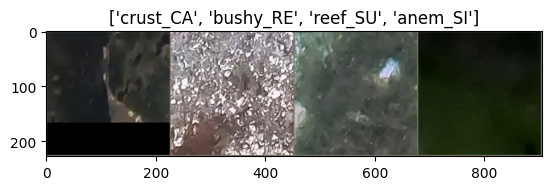

In [21]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [22]:
# Training function copied from pytorch documentation
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [23]:
# Visualize model predictions function also copied from pytorch documentation

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
# Training model parameter set up
# copied from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet

num_ftrs = model._fc.in_features

# we defined the class_names above
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4600 Acc: 0.3155
val Loss: 6.9404 Acc: 0.0043

Epoch 1/24
----------
train Loss: 2.2820 Acc: 0.3478
val Loss: 7.2376 Acc: 0.0009

Epoch 2/24
----------
train Loss: 2.2373 Acc: 0.3595
val Loss: 7.4966 Acc: 0.0048

Epoch 3/24
----------
train Loss: 2.2029 Acc: 0.3696
val Loss: 7.2265 Acc: 0.0038

Epoch 4/24
----------
train Loss: 2.1772 Acc: 0.3747
val Loss: 6.6911 Acc: 0.0092

Epoch 5/24
----------
train Loss: 2.1498 Acc: 0.3824
val Loss: 7.4006 Acc: 0.0043

Epoch 6/24
----------
train Loss: 2.1312 Acc: 0.3874
val Loss: 7.3905 Acc: 0.0078

Epoch 7/24
----------
train Loss: 2.0767 Acc: 0.4023
val Loss: 7.7624 Acc: 0.0076

Epoch 8/24
----------
train Loss: 2.0629 Acc: 0.4048
val Loss: 7.8285 Acc: 0.0077

Epoch 9/24
----------
train Loss: 2.0553 Acc: 0.4062
val Loss: 7.8633 Acc: 0.0076

Epoch 10/24
----------
train Loss: 2.0523 Acc: 0.4080
val Loss: 7.9192 Acc: 0.0091

Epoch 11/24
----------
train Loss: 2.0456 Acc: 0.4097
val Loss: 7.9152 Acc: 0.0085

Ep

In [26]:
print("Model's state_dict:")
for param_tensor in model_ft.state_dict():
    print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

Model's state_dict:
_conv_stem.weight 	 torch.Size([32, 3, 3, 3])
_bn0.weight 	 torch.Size([32])
_bn0.bias 	 torch.Size([32])
_bn0.running_mean 	 torch.Size([32])
_bn0.running_var 	 torch.Size([32])
_bn0.num_batches_tracked 	 torch.Size([])
_blocks.0._depthwise_conv.weight 	 torch.Size([32, 1, 3, 3])
_blocks.0._bn1.weight 	 torch.Size([32])
_blocks.0._bn1.bias 	 torch.Size([32])
_blocks.0._bn1.running_mean 	 torch.Size([32])
_blocks.0._bn1.running_var 	 torch.Size([32])
_blocks.0._bn1.num_batches_tracked 	 torch.Size([])
_blocks.0._se_reduce.weight 	 torch.Size([8, 32, 1, 1])
_blocks.0._se_reduce.bias 	 torch.Size([8])
_blocks.0._se_expand.weight 	 torch.Size([32, 8, 1, 1])
_blocks.0._se_expand.bias 	 torch.Size([32])
_blocks.0._project_conv.weight 	 torch.Size([16, 32, 1, 1])
_blocks.0._bn2.weight 	 torch.Size([16])
_blocks.0._bn2.bias 	 torch.Size([16])
_blocks.0._bn2.running_mean 	 torch.Size([16])
_blocks.0._bn2.running_var 	 torch.Size([16])
_blocks.0._bn2.num_batches_tracked 	 to

In [36]:
today = str(date.today())
transfer_trained_model_statedict_path = "./model/efficientnet_b0_statedict" + today + ".pt"
transfer_trained_model__path = "./model/efficientnet_b0_" + today + ".pt"
print(output_path)

./model/efficientnet_b0_2024-06-08.pt


In [37]:
torch.save(model_ft.state_dict(), transfer_trained_model_statedict_path)

In [38]:
torch.save(model_ft, transfer_trained_model__path)

In [40]:
# transfer_trained_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=64)
# transfer_state_dicts = torch.load(transfer_trained_model_path)

# transfer_new_state_dicts = OrderedDict()
# for k, v in transfer_state_dicts['net'].items():
#     name = k[7:]
#     transfer_new_state_dicts[name] = v
            
transfer_trained_model = torch.load(transfer_trained_model_path)
transfer_trained_model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    